**Import dependecies**

In [1]:
'''
%conda install -c apple tensorflow-deps scipy #macos
%pip install tensorflow-macos tensorflow-metal #macos

%pip install --upgrade tensorflow 
%pip install pydot graphviz

%pip install pandas numpy pillow matplotlib scipy autopep8 pydot
'''

'\n%conda install -c apple tensorflow-deps scipy #macos\n%pip install tensorflow-macos tensorflow-metal #macos\n\n%pip install --upgrade tensorflow \n%pip install pydot graphviz\n\n%pip install pandas numpy pillow matplotlib scipy autopep8 pydot\n'

In [2]:
%load_ext tensorboard

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import os
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
import datetime

fruit = "apple"
model_current = "vgg16"
curr_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run_prefix = f'./runs/{fruit}/{model_current}/{curr_datetime}/'
#results_prefix = f'./results/{fruit}/{model_current}/{curr_datetime}/'
log_dir = f'logs/fit/{fruit}/{model_current}/{curr_datetime}'
os.makedirs(run_prefix, exist_ok=True)
#os.makedirs(results_prefix, exist_ok=True)
run_prefix


'./runs/apple/vgg16/20220731-191211/'

**Create an imagedatagenerator object to label data**

In [6]:
input_size = 128
batch_size = 16
train_size = 8000
test_size = 2000
learning_rate = 0.0001
epochs = 150
dropout = 0.0
dense_size = 1024

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
train_dir = f"./dataset_frutas_colab/{fruit}/train"
test_dir = f"./dataset_frutas_colab/{fruit}/test"
train_generator = train_datagen.flow_from_directory(train_dir,batch_size=batch_size,class_mode = 'binary', shuffle= True, target_size=(input_size,input_size))
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=batch_size,class_mode = 'binary',shuffle= True, target_size=(input_size,input_size))

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


VGG16 model

In [7]:
pre_trained_model = VGG16(
    input_shape = (input_size,input_size,3),
    include_top = False,
    weights='imagenet'
)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-31 19:12:11.844484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-31 19:12:11.845035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Start transfer learning process

In [8]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [9]:
import tensorflow as tf
#Flatten
x = layers.Flatten()(pre_trained_model.output)
#Fully connected layer con 1,024 hidden units y ReLU
x = layers.Dense(dense_size, activation='relu')(x)
x = layers.Dense(dense_size/2, activation='relu')(x)
#Dropout rate
if (dropout>0):
    x = layers.Dropout(dropout)(x)
#Binary classification and sigmoid func
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics = [tf.keras.metrics.Accuracy(),
                         tf.keras.metrics.Precision(), 
                         tf.keras.metrics.Recall()])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [11]:
tf.keras.utils.plot_model(
    model,
    to_file=f"{run_prefix}model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)
print("Saved Model Image")

Saved Model Image


In [12]:
import datetime

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(
    train_generator,
    validation_data = test_generator,
    steps_per_epoch = train_size/batch_size,
    epochs = epochs,
    validation_steps = test_size/batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/150


2022-07-31 19:12:13.532464: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-31 19:12:14.156491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.0000e+00 - precision: 0.9183 - recall: 0.9295

2022-07-31 19:12:43.715597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 37s 68ms/step - loss: 0.1869 - accuracy: 0.0000e+00 - precision: 0.9183 - recall: 0.9295 - val_loss: 0.0662 - val_accuracy: 0.0000e+00 - val_precision: 0.9779 - val_recall: 0.9740
Epoch 2/150
500/500 [==============================] - 33s 66ms/step - loss: 0.0779 - accuracy: 0.0000e+00 - precision: 0.9672 - recall: 0.9733 - val_loss: 0.0566 - val_accuracy: 0.0000e+00 - val_precision: 0.9741 - val_recall: 0.9790
Epoch 3/150
500/500 [==============================] - 36s 72ms/step - loss: 0.0456 - accuracy: 2.5000e-04 - precision: 0.9813 - recall: 0.9860 - val_loss: 0.0543 - val_accuracy: 0.0000e+00 - val_precision: 0.9948 - val_recall: 0.9620
Epoch 4/150
500/500 [==============================] - 33s 66ms/step - loss: 0.0389 - accuracy: 0.0019 - precision: 0.9853 - recall: 0.9883 - val_loss: 0.0389 - val_accuracy: 5.0000e-04 - val_precision: 0.9879 - val_recall: 0.9800
Epoch 5/150
500/500 [==============================] - 33s 66ms/step - loss:

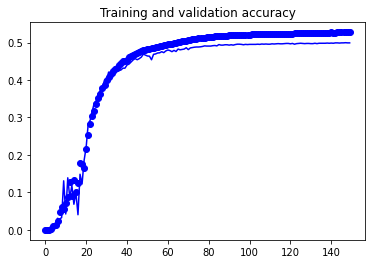

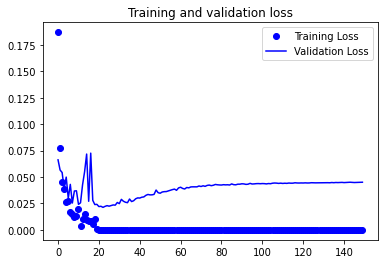

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
recall = history.history['recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.savefig(f"{run_prefix}acc.svg")
plt.figure()


plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(f"{run_prefix}loss.svg")

plt.show()

In [14]:
#model.save(f"{run_prefix}{model_current}.h5")

In [15]:
import csv

header = ["train_acc", "val_acc", "train_loss", "val_loss", "precision", "recall"]

with open(f'{run_prefix}metrics.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)
    for idx in range(len(acc)):
        line = [acc[idx],val_acc[idx],loss[idx],val_loss[idx], precision[idx], recall[idx]]        
        writer.writerow(line)
